In [1]:
# imports
import glob
from pprint import pprint

import numpy as np
import matplotlib.pyplot as plt

from pyquaternion import Quaternion
from nuscenes.nuscenes import NuScenes
from nuscenes.utils.geometry_utils import transform_matrix
from nuscenes.utils.data_classes import RadarPointCloud

In [2]:
# basic config and variables
_VERSION = 'v1.0-mini'
_DATAROOT = '/home/jovyan/praktikum-datafusion/data'

nusc = NuScenes(version=_VERSION, dataroot=_DATAROOT, verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.508 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [3]:
# get all the point cloud files

def get_all_radar_file_paths() -> list:
    """get the absolute file paths for all radar sample binaries."""
    return glob.glob(f'{_DATAROOT}/samples/RADAR_*/*.pcd')


# determine the first listed radar file as testfile
test_pcd_file = get_all_radar_file_paths()[0]

In [4]:
def get_pcd_data(nusc_filepath: str):
    radar_point_cloud = RadarPointCloud.from_file(nusc_filepath)
    points =  radar_point_cloud.points
    x = points[0]
    y = points[1]
    vx_comp = points[8]
    vy_comp = points[9]

    return {
        'file': nusc_filepath,
        'x': x,
        'y': y,
        'vx_comp': vx_comp,
        'vy_comp': vy_comp,
        'v_comp': (vx_comp ** 2 + vy_comp ** 2) ** 0.5,
        'radar_point_cloud': radar_point_cloud
    }


result = get_pcd_data(test_pcd_file)
pprint(result)

{'file': '/home/jovyan/praktikum-datafusion/data/samples/RADAR_FRONT_LEFT/n008-2018-08-30-15-16-55-0400__RADAR_FRONT_LEFT__1535657112652791.pcd',
 'radar_point_cloud': <nuscenes.utils.data_classes.RadarPointCloud object at 0x7fdf34e281c0>,
 'v_comp': array([0.06058678, 0.00131722, 0.18726687, 0.00372698, 0.00440891,
       0.10485904, 0.09731367, 0.08306185]),
 'vx_comp': array([ 0.05695982, -0.00129671,  0.10772915,  0.00253038, -0.00362606,
        0.08181776,  0.06581847, -0.08104935]),
 'vy_comp': array([-0.02064793,  0.00023156,  0.15317738, -0.00273634, -0.00250802,
        0.06558408,  0.07167901,  0.01817344]),
 'x': array([ 8.        ,  8.39999962,  6.4000001 ,  8.60000038, 12.        ,
       12.60000038, 14.60000038, 38.79999924]),
 'y': array([-2.9000001 , -1.5       ,  9.10000038, -9.30000019,  8.30000019,
       10.10000038, 15.89999962, -8.69999981])}


In [5]:
# help(RadarPointCloud)

# nusc.sample_data[0]

# nusc.get('sample', '39586f9d59004284a7114a68825e8eec')

sc = nusc.scene[0]

sc

{'token': 'cc8c0bf57f984915a77078b10eb33198',
 'log_token': '7e25a2c8ea1f41c5b0da1e69ecfa71a2',
 'nbr_samples': 39,
 'first_sample_token': 'ca9a282c9e77460f8360f564131a8af5',
 'last_sample_token': 'ed5fc18c31904f96a8f0dbb99ff069c0',
 'name': 'scene-0061',
 'description': 'Parked truck, construction, intersection, turn left, following a van'}

In [6]:
# extract samples


def extract_samples_from_scene(scene: dict):
    """extract all the samples related to the given scene."""
    first_sample_token = scene['first_sample_token']
    last_sample_token = scene['last_sample_token']
    samples = list()

    fst = nusc.get('sample', first_sample_token)
    next_token = fst['next']
    while True:
        current = nusc.get('sample', next_token)
        samples.append(current)
        next_token = current['next']
        if next_token == last_sample_token:
            return samples
    # return first_sample_token, last_sample_token, scene

samples_from_scene = extract_samples_from_scene(sc)

def extract_channel_from_file(channel: str):
    filename = nusc.get('sample_data', channel)['filename']
    filename = f'{_DATAROOT}/{filename}'
    return get_pcd_data(filename)

def convert_binary_data_to_coordinates_and_velocity(sample: dict):
    data = sample['data']
    return {
     'RADAR_FRONT' : extract_channel_from_file(data['RADAR_FRONT']),
     'RADAR_FRONT_LEFT' : extract_channel_from_file(data['RADAR_FRONT_LEFT']),
     'RADAR_FRONT_RIGHT' : extract_channel_from_file(data['RADAR_FRONT_RIGHT']),
     'RADAR_BACK_LEFT' : extract_channel_from_file(data['RADAR_BACK_LEFT']),
     'RADAR_BACK_RIGHT' : extract_channel_from_file(data['RADAR_BACK_RIGHT']),
     'data': data
    }

scene_in_sample_data = [convert_binary_data_to_coordinates_and_velocity(sc) for sc in samples_from_scene]

In [7]:
# sc
def get_ego_pose_from_timestamp(timestamp: int) -> dict:
    return [s for s  in nusc.ego_pose if s['timestamp'] == timestamp][0]

ego_poses_from_scene = [get_ego_pose_from_timestamp(s['timestamp']) for s in extract_samples_from_scene(sc)]

coordinates_from_scene = [(c[0],c[1]) for c in [s['translation'] for s in ego_poses_from_scene]]

coordinates_from_scene

[(409.7431520488096, 1176.6769733781416),
 (408.101879146712, 1172.1515777892457),
 (406.7260055966978, 1168.2112865775816),
 (405.40940618082874, 1164.3542269452469),
 (404.27766613575534, 1161.0501064609266),
 (403.1147868052399, 1157.5179992427084),
 (401.882035855894, 1153.723115401486),
 (400.84139513617623, 1150.4041654308548),
 (399.84353161665877, 1147.1735328106026),
 (399.0198373002425, 1144.398545717494),
 (398.16712901294835, 1141.370496193884),
 (397.4476741975414, 1138.4704918742955),
 (396.8835035523236, 1135.6564273770866),
 (396.4443552268204, 1132.6271305081405),
 (396.28709579417813, 1130.0546235114005),
 (396.3721334319953, 1127.5762883014086),
 (396.6816902790987, 1125.2563692026397),
 (397.1853086632334, 1123.0598472868774),
 (397.8606615606245, 1121.0773884177784),
 (398.7597041521511, 1119.1284635254908),
 (399.9076584877769, 1117.2088940698718),
 (401.0653931407355, 1115.6784191807697),
 (402.47435861332616, 1114.1490807505795),
 (404.11369592844784, 1112.67625

In [8]:
# lt = sc['log_token']

# mt = nusc.get('log', lt)['map_token']

# mapfile = f"{_DATAROOT}/{nusc.get('map',mt)['filename']}"

# im = plt.imread(mapfile)
# implot = plt.imshow(im)

# map_x = np.array([c[0] for c in coordinates_from_scene])
# map_y = np.array([c[1] for c in coordinates_from_scene])
# plt.scatter(x=map_x, y=map_y, c="r")

# plt.show()

In [9]:
raw_data = [{
    'translation': np.array(s['translation']),
    'rotation': Quaternion(s['rotation']),
    } for s in ego_poses_from_scene]

trans = [transform_matrix(e['translation'], e['rotation']) for e in raw_data]



new_arr = np.array([[c[0], c[1], 0.0, 0.0] for c in coordinates_from_scene])

# trans @ np.reshape(map_x, (37,1))

In [10]:
sensors = filter(lambda s: s['modality'] == 'radar', nusc.sensor)

RADAR_CHANNELS = {
        'RADAR_FRONT': list(filter(lambda s: s['channel'] == 'RADAR_FRONT', nusc.sensor)),
        'RADAR_FRONT_LEFT': list(filter(lambda s: s['channel'] == 'RADAR_FRONT_LEFT', nusc.sensor)),
        'RADAR_FRONT_RIGHT': list(filter(lambda s: s['channel'] == 'RADAR_FRONT_RIGHT', nusc.sensor)),
        'RADAR_BACK_LEFT': list(filter(lambda s: s['channel'] == 'RADAR_BACK_LEFT', nusc.sensor)),
        'RADAR_BACK_RIGHT': list(filter(lambda s: s['channel'] == 'RADAR_BACK_RIGHT', nusc.sensor)),
}

list(sensors)

[{'token': '47fcd48f71d75e0da5c8c1704a9bfe0a',
  'channel': 'RADAR_FRONT',
  'modality': 'radar'},
 {'token': '232a6c4dc628532e81de1c57120876e9',
  'channel': 'RADAR_FRONT_RIGHT',
  'modality': 'radar'},
 {'token': '1f69f87a4e175e5ba1d03e2e6d9bcd27',
  'channel': 'RADAR_FRONT_LEFT',
  'modality': 'radar'},
 {'token': 'df2d5b8be7be55cca33c8c92384f2266',
  'channel': 'RADAR_BACK_LEFT',
  'modality': 'radar'},
 {'token': '5c29dee2f70b528a817110173c2e71b9',
  'channel': 'RADAR_BACK_RIGHT',
  'modality': 'radar'}]

In [59]:
def new_method():
    """makes a biggo matrix containing all infos about 2 a)."""
    channels = [
        'RADAR_FRONT',
        'RADAR_FRONT_LEFT',
        'RADAR_FRONT_RIGHT',
        'RADAR_BACK_LEFT',
        'RADAR_BACK_RIGHT',
    ]
    samples = scene_in_sample_data
    scene_points = list()
    for sample in samples:
        x, y, z, vx_comp, vy_comp, pointclouds = list(), list(), list() ,list() ,list(), list()
        for channel in channels:
            pc = sample[channel]['radar_point_cloud']
            radar_token = sample['data'][channel]
            current_radar = nusc.get('sample_data', radar_token)
            ego_pose = nusc.get('ego_pose', current_radar['ego_pose_token'])
            calibrated_sensor = nusc.get('calibrated_sensor', current_radar['calibrated_sensor_token'])
            sensor_to_car = transform_matrix(calibrated_sensor['translation'], Quaternion(calibrated_sensor['rotation'], inverse=False))
            car_to_world = transform_matrix(ego_pose['translation'], Quaternion(ego_pose['rotation'], inverse=False))

            sensor_to_world = np.dot(car_to_world, sensor_to_car)

            pc.transform(sensor_to_world)

            pointclouds.append(pc)

            # combine radar
            for i in range(pc.points.shape[1]):
                x.append(pc.points[0][i])
                y.append(pc.points[1][i])
                z.append(pc.points[2][i]) # redundant?
                vx_comp.append(pc.points[7][i])
                vy_comp.append(pc.points[8][i])
        scene_points.append([
            np.asarray(x),
            np.asarray(y),
            np.asarray(z),
            np.asarray(vx_comp),
            np.asarray(vy_comp),
            np.asarray(pointclouds)
        ])

    return np.asarray(scene_points)


result = new_method()

/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [61]:
np.shape(result)

(37, 6)

(37,)

In [81]:
[1,2] + list(np.array([3,4]))

[1, 2, 3, 4]

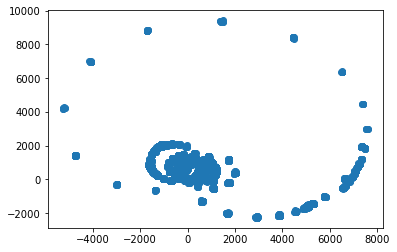

In [82]:
ys = list()
xs = list()

for row in result:
    x, y = row[0], row[1]
    xs += list(x)
    ys += list(y)



plt.scatter(x=xs, y=ys)
plt.show()